In [1]:
#from google.colab import auth
import os
import pandas as pd

#new
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.0f}'.format

#auth.authenticate_user()
#os.chdir('/content/dataset/')

df = pd.read_csv('Supermarket.csv')
print(df.shape)
df.head()

conn = sql.connect("supermarket.db")
df.to_sql("table1", conn, if_exists='replace')
sql_string = "select * from table1"
df = pd.read_sql(sql_string, conn)
df.head()
df.shape

sql ='''
SELECT CUST_CODE, 
SUM(SPEND) AS TOTAL_SALES, 
COUNT(DISTINCT BASKET_ID) AS TOTAL_VISIT 
FROM 'table1'
WHERE CUST_CODE IS NOT NULL 
GROUP BY CUST_CODE
'''

df = pd.read_sql(sql, conn)
print(df.head())

df.to_csv (r'cust_segment.csv', index = False, header=True)

<H1> Prepare Data </H1>

In [2]:
df = pd.read_csv("cust_segment.csv", header=0)
print(df)

           CUST_CODE  TOTAL_SALES  TOTAL_VISIT
0     CUST0000000013          160           12
1     CUST0000000055          434           15
2     CUST0000000679           86           14
3     CUST0000001052          261           31
4     CUST0000001058           72            2
...              ...          ...          ...
4995  CUST0000998609           54           14
4996  CUST0000998851          395           23
4997  CUST0000998907         3721          177
4998  CUST0000999385         4253          313
4999  CUST0000999786          803          130

[5000 rows x 3 columns]


<H1>Visualize distribution of variables

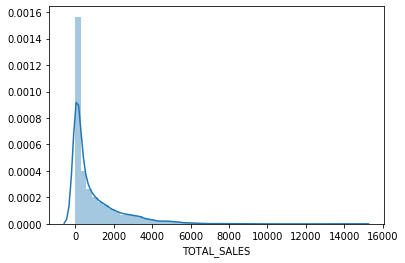

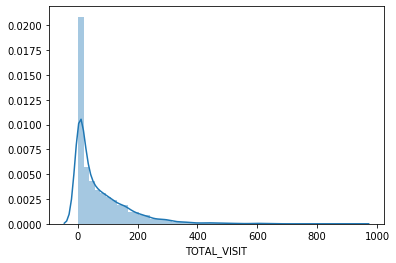

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for i, col in enumerate(df.columns[1:]):
    plt.figure(i)
    sns.distplot(df[col])
    
plt.show()


<H1> Standardize data

In [4]:
from sklearn.preprocessing import StandardScaler

df_std = pd.DataFrame(StandardScaler().fit_transform(df[df.columns[1:]]))
df_std.head(5)

,0,1
0,-1,-1
1,-0,-1
2,-1,-1
3,-1,-0
4,-1,-1


<H1> Find optimum k using elbow method

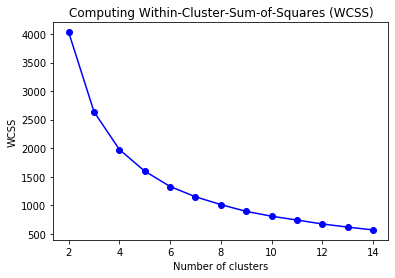

In [5]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(2, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(df_std)
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("Computing Within-Cluster-Sum-of-Squares (WCSS)")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()


For n_clusters = 2 The average silhouette_score is : 0.660551050342386
For n_clusters = 3 The average silhouette_score is : 0.6086291021846851
For n_clusters = 4 The average silhouette_score is : 0.5870995064343884
For n_clusters = 5 The average silhouette_score is : 0.5604484947852854
For n_clusters = 6 The average silhouette_score is : 0.5700417929715328
For n_clusters = 7 The average silhouette_score is : 0.5296356900147727
For n_clusters = 8 The average silhouette_score is : 0.5361044718987478
For n_clusters = 9 The average silhouette_score is : 0.5339773775058744
For n_clusters = 10 The average silhouette_score is : 0.5299370187545283
For n_clusters = 11 The average silhouette_score is : 0.5285621544420656
For n_clusters = 12 The average silhouette_score is : 0.5264718375668052
For n_clusters = 13 The average silhouette_score is : 0.4949411829537541
For n_clusters = 14 The average silhouette_score is : 0.4955378263261703


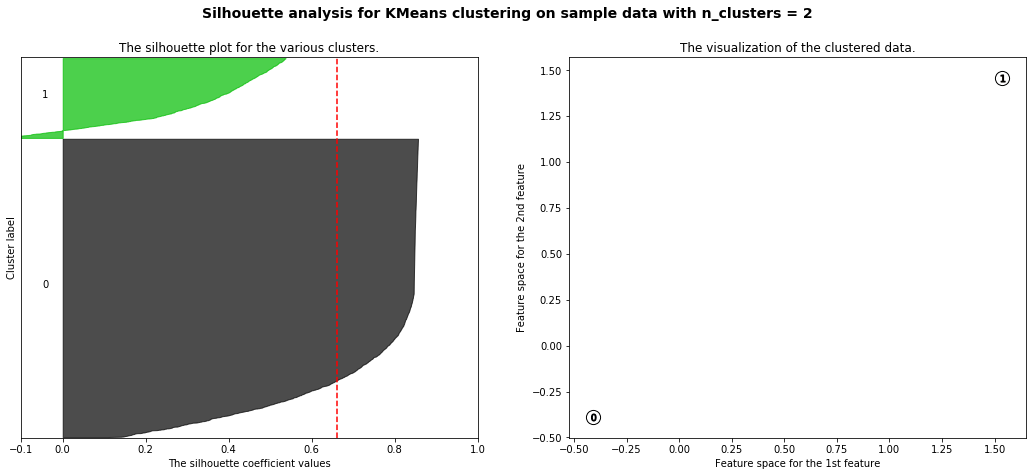

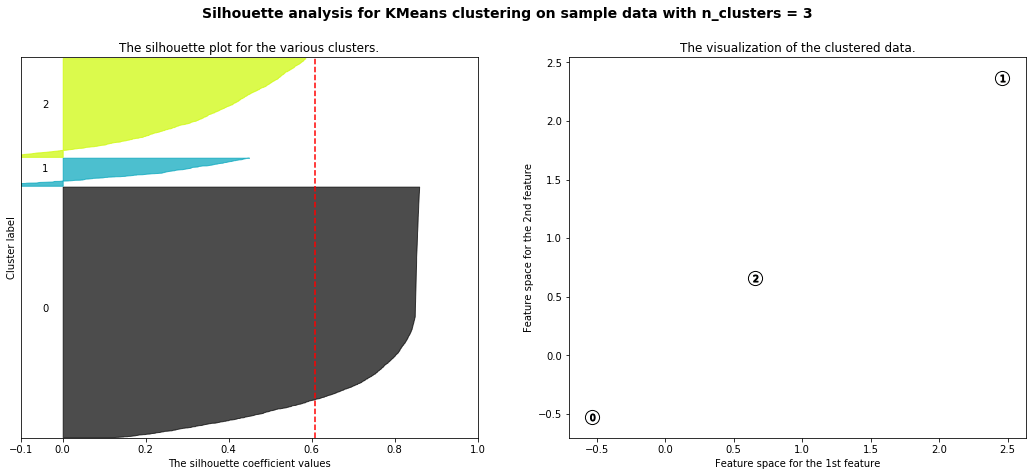

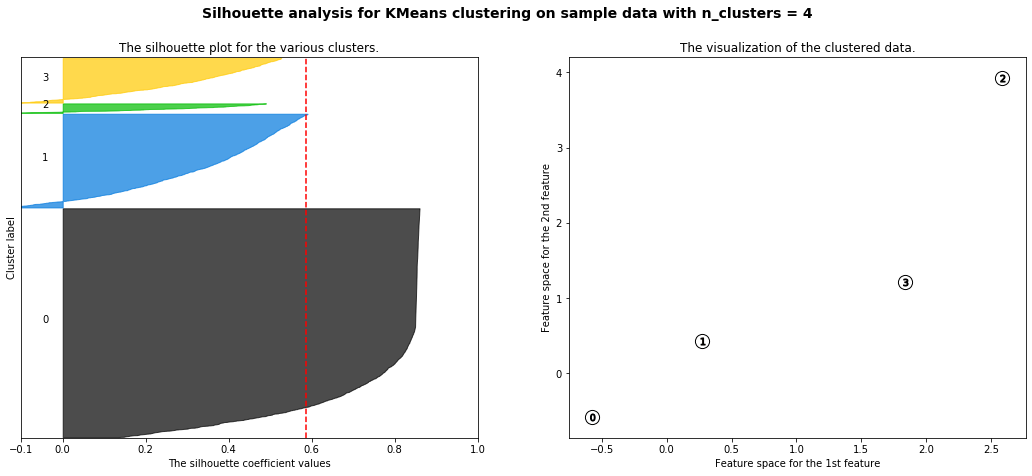

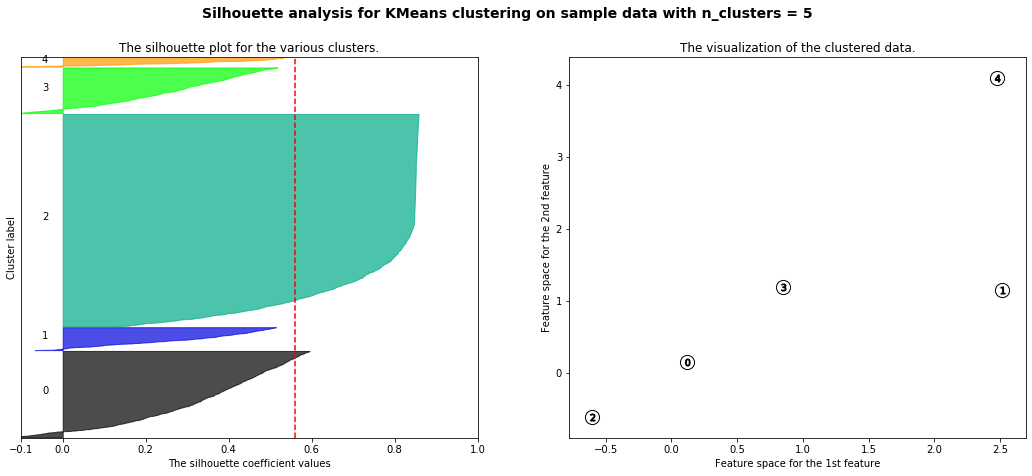

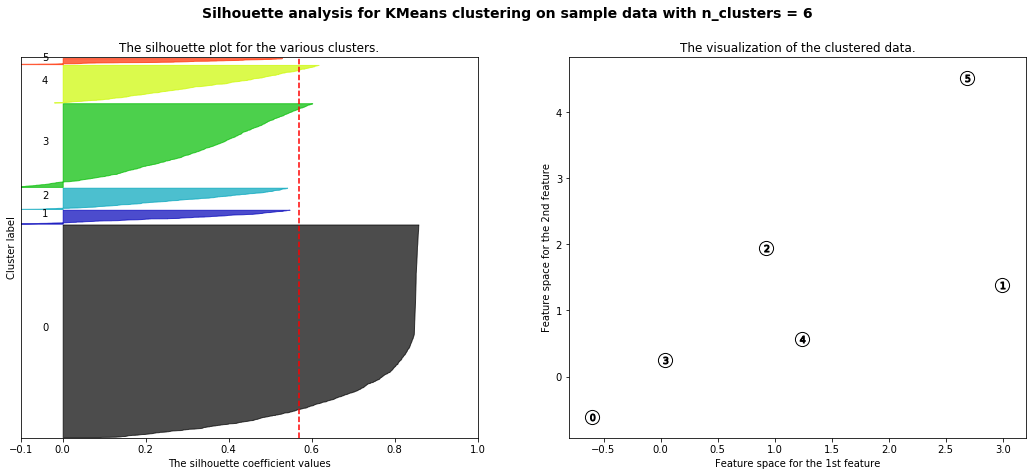

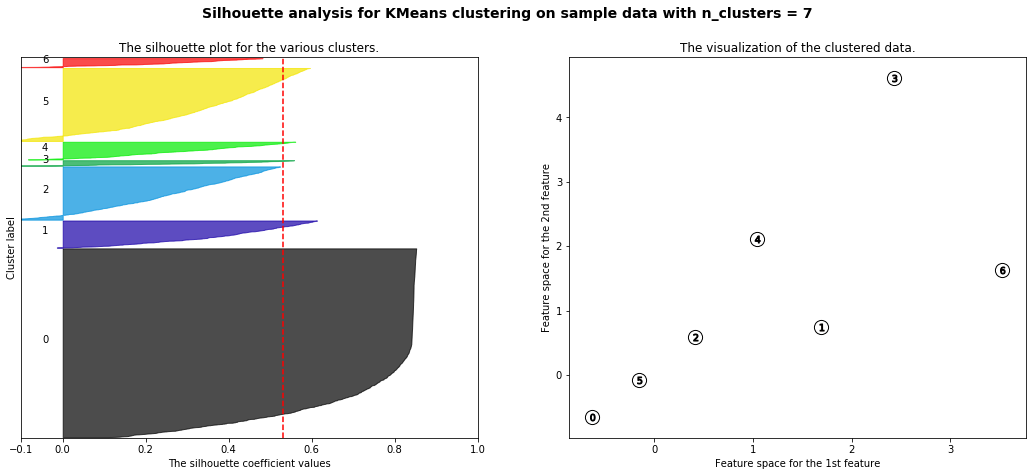

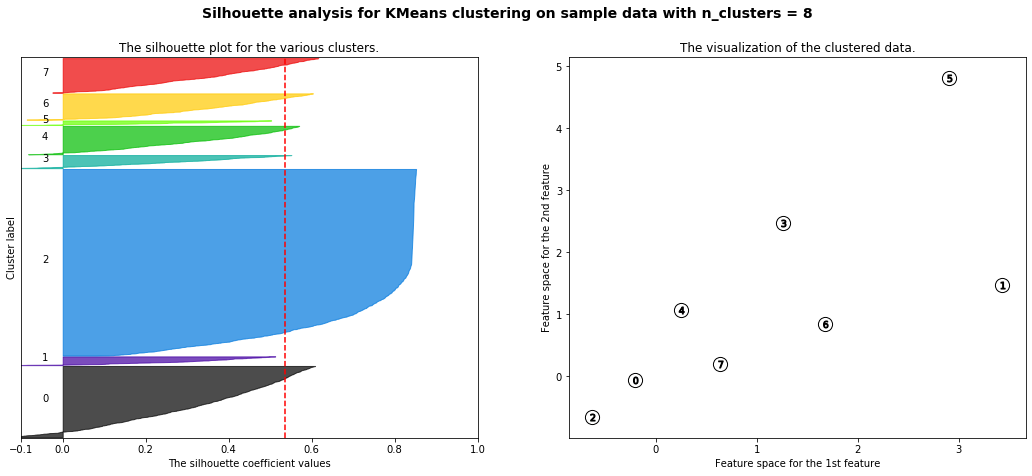

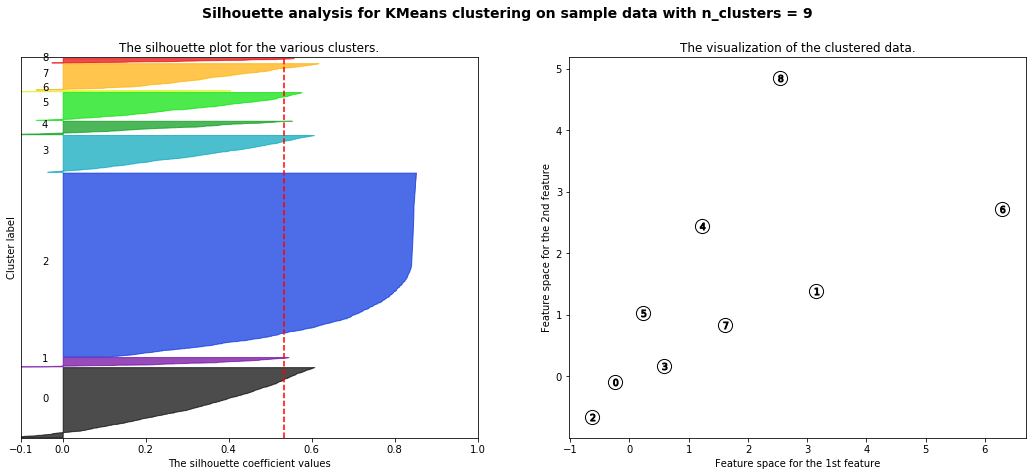

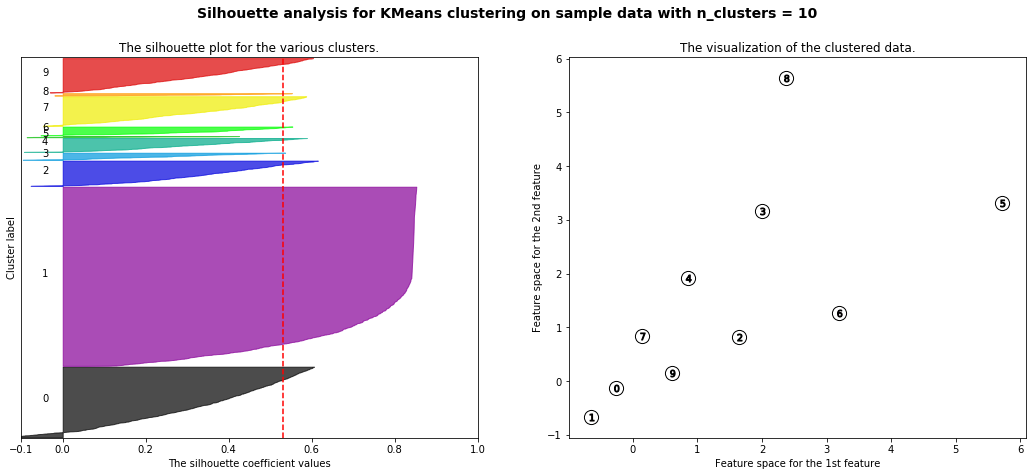

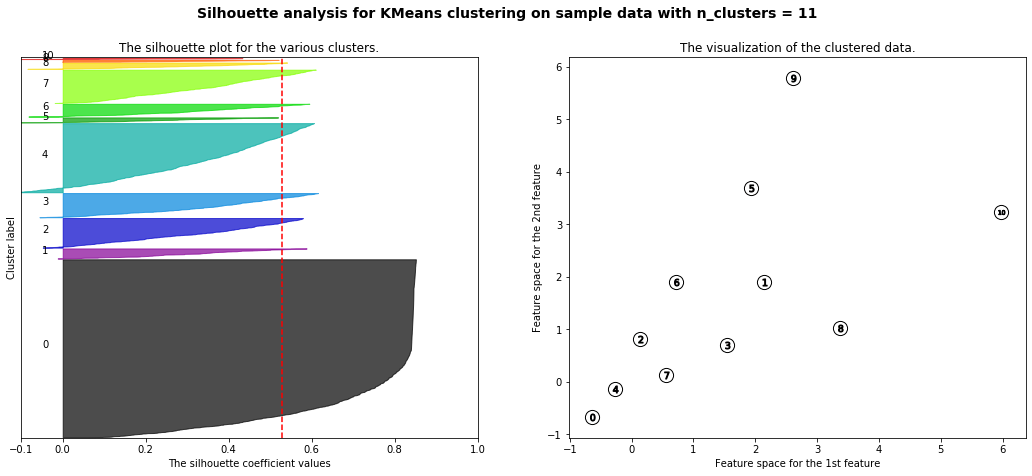

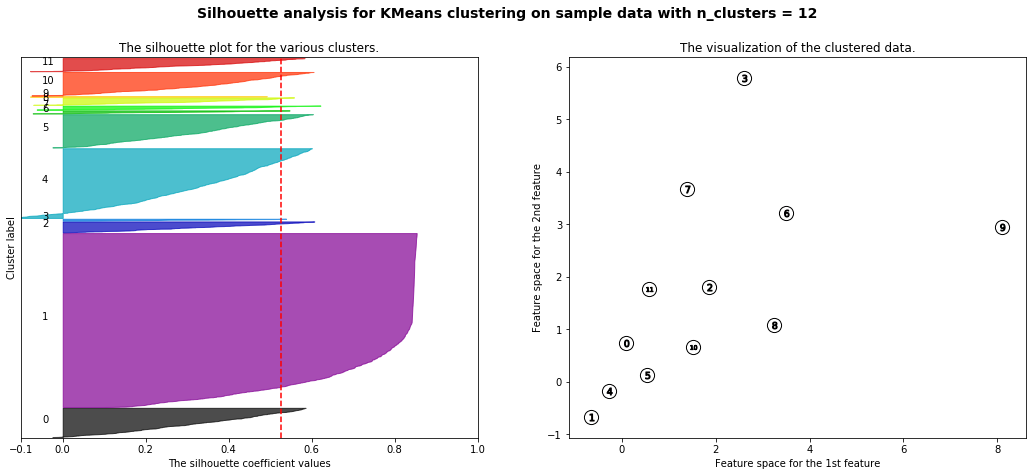

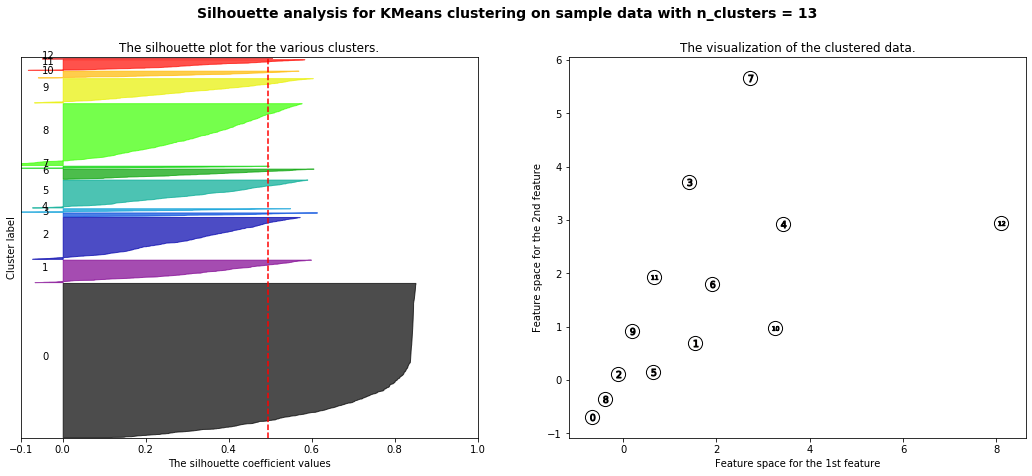

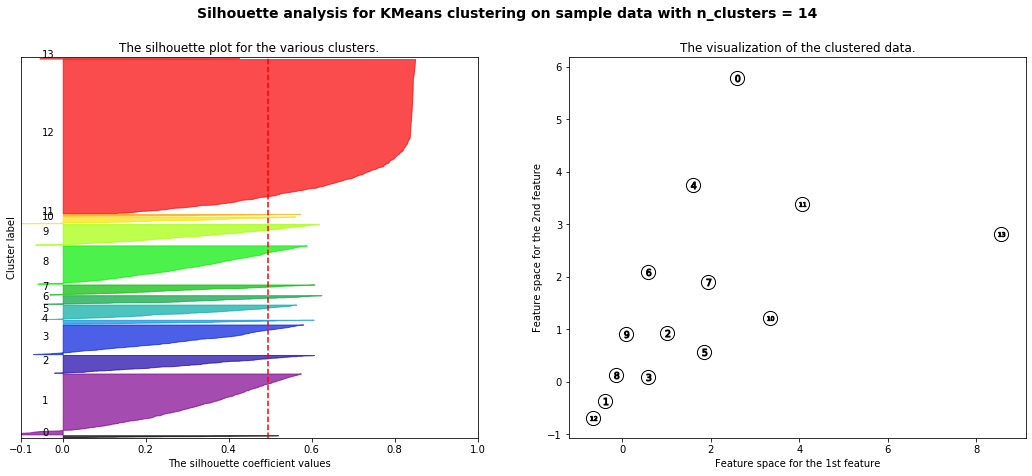

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

ss = []

for n_clusters in N:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_std) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_std)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_std, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_std, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

<H1> K-means clustering

In [7]:
cluster = KMeans(n_clusters=7)
df['cluster'] = cluster.fit_predict(df_std)
print(df)

           CUST_CODE  TOTAL_SALES  TOTAL_VISIT  cluster
0     CUST0000000013          160           12        1
1     CUST0000000055          434           15        1
2     CUST0000000679           86           14        1
3     CUST0000001052          261           31        1
4     CUST0000001058           72            2        1
...              ...          ...          ...      ...
4995  CUST0000998609           54           14        1
4996  CUST0000998851          395           23        1
4997  CUST0000998907         3721          177        5
4998  CUST0000999385         4253          313        2
4999  CUST0000999786          803          130        0

[5000 rows x 4 columns]


<H1> Determine average behaviors of each cluster </H1>

In [8]:
dfCluster = df.groupby('cluster', as_index=False).mean()
print(dfCluster)
dfCluster['NUM_CUST'] = df[['cluster','CUST_CODE']].groupby('cluster').count()

dfCluster


   cluster  TOTAL_SALES  TOTAL_VISIT
0        0         1515          140
1        1          119           12
2        2         5614          241
3        3         2368          294
4        4          769           70
5        5         3213          152
6        6         4352          551


,cluster,TOTAL_SALES,TOTAL_VISIT,NUM_CUST
0,0,1515,140,696
1,1,119,12,2540
2,2,5614,241,123
3,3,2368,294,237
4,4,769,70,969
5,5,3213,152,363
6,6,4352,551,72


<H1> Visualize Clustering Results – Scatter Plot </H1>

<Figure size 432x288 with 0 Axes>

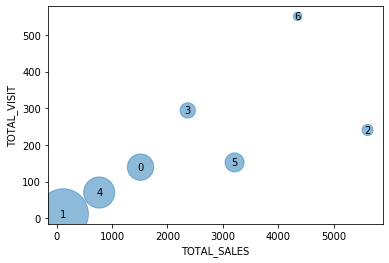

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TOTAL_SALES'], dfCluster['TOTAL_VISIT'], s=dfCluster['NUM_CUST'], alpha = 0.5)
ax.set_xlabel("TOTAL_SALES")
ax.set_ylabel("TOTAL_VISIT")

for i, txt in enumerate(dfCluster['cluster']):
    ax.annotate(txt, 
                (dfCluster['TOTAL_SALES'][i], 
                dfCluster["TOTAL_VISIT"][i]), 
                horizontalalignment='center',
                verticalalignment='center')

plt.show()


<H1>Visualize Clustering Results – Box Plot</H1>

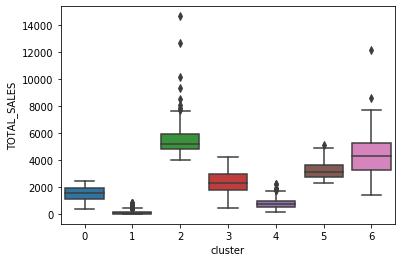

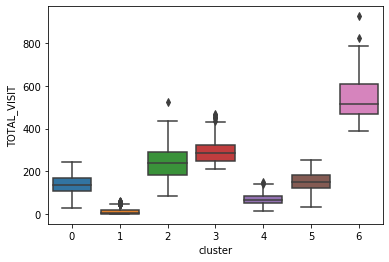

In [10]:
for i, col in enumerate(df.columns[1:-1]):
    sns.boxplot(x="cluster", y =col, data=df)
    plt.show()

<H1>Employ RandomForest to determine important variables</H1>

In [11]:
from sklearn.ensemble import RandomForestClassifier

predictors = df.iloc[:,1:-1]
print(predictors)
targets = df.iloc[:,-1:]
print(targets)

scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(predictors_scaled, targets.values.ravel())

      TOTAL_SALES  TOTAL_VISIT
0             160           12
1             434           15
2              86           14
3             261           31
4              72            2
...           ...          ...
4995           54           14
4996          395           23
4997         3721          177
4998         4253          313
4999          803          130

[5000 rows x 2 columns]
      cluster
0           1
1           1
2           1
3           1
4           1
...       ...
4995        1
4996        1
4997        5
4998        2
4999        0

[5000 rows x 1 columns]


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

<H1>List important variables </H1>

In [12]:
importances = list(classifier.feature_importances_)

feature_list = list(predictors.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: TOTAL_SALES          Importance: 0.54
Variable: TOTAL_VISIT          Importance: 0.46
